**This Notebook contains two tasks**

*(Custom models with accuracy more than 85% and transfer learning)*

**Importing libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from google.colab import files
from zipfile import ZipFile
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import InceptionResNetV2

**Loading the data**

In [2]:
# !pip install kaggle

In [3]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"invalidcoder","key":"1dd1a92dbc83806575b9cbd7a17f98a2"}'}

In [4]:
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

In [5]:
# !kaggle datasets download -d omkargurav/face-mask-dataset

 96% 157M/163M [00:01<00:00, 112MB/s] 
100% 163M/163M [00:01<00:00, 120MB/s]


In [6]:
file_name = 'face-mask-dataset.zip'

with ZipFile(file_name, 'r') as zip:
    zip.extractall()
    print("Done")

Done


In [7]:
batch_size = 40
img_height = 200
img_width = 200

In [8]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [9]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    'data',
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [10]:
class_names = train_data.class_names

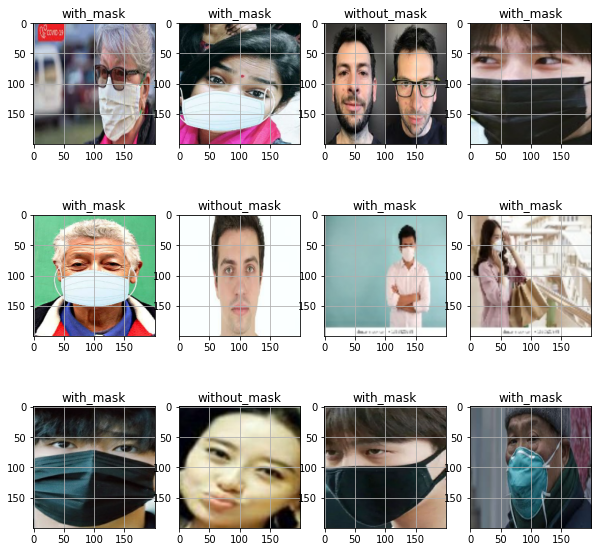

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_data.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.grid(True)

**Configuring datasets for performance**

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_data = train_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

**Modeling**

Using flatten layer will increase the size of the model,

hence use Global avg Pooling instead.

Is it necessary to include input_shape in the first layer? (input_shape=(200,200,3))

Does it affect the performance?

In [13]:
model = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(2, activation='softmax')
])

In [14]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Training my CNN**

In [15]:
retVal = model.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
152/152 [==============================] - 23s 110ms/step - loss: 0.6407 - accuracy: 0.6225 - val_loss: 0.5852 - val_accuracy: 0.6583
Epoch 2/15
152/152 [==============================] - 4s 29ms/step - loss: 0.5417 - accuracy: 0.7295 - val_loss: 0.5744 - val_accuracy: 0.6722
Epoch 3/15
152/152 [==============================] - 4s 29ms/step - loss: 0.5307 - accuracy: 0.7406 - val_loss: 0.5030 - val_accuracy: 0.7576
Epoch 4/15
152/152 [==============================] - 4s 29ms/step - loss: 0.5005 - accuracy: 0.7611 - val_loss: 0.4737 - val_accuracy: 0.7874
Epoch 5/15
152/152 [==============================] - 4s 29ms/step - loss: 0.4560 - accuracy: 0.7876 - val_loss: 0.3914 - val_accuracy: 0.8397
Epoch 6/15
152/152 [==============================] - 5s 30ms/step - loss: 0.3885 - accuracy: 0.8323 - val_loss: 0.3472 - val_accuracy: 0.8596
Epoch 7/15
152/152 [==============================] - 4s 29ms/step - loss: 0.3362 - accuracy: 0.8684 - val_loss: 0.2876 - val_accuracy: 0.89

**Let's visualize the result of training.**

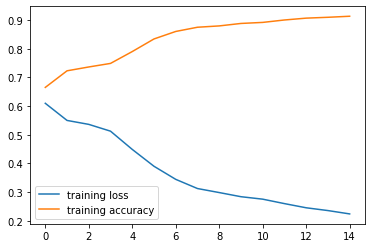

In [16]:
plt.plot(retVal.history['loss'], label='training loss')
plt.plot(retVal.history['accuracy'], label='training accuracy')
plt.legend()

Is it bad when the learning curve looks almost like a line?

Let's match the predicted labels with  real images.

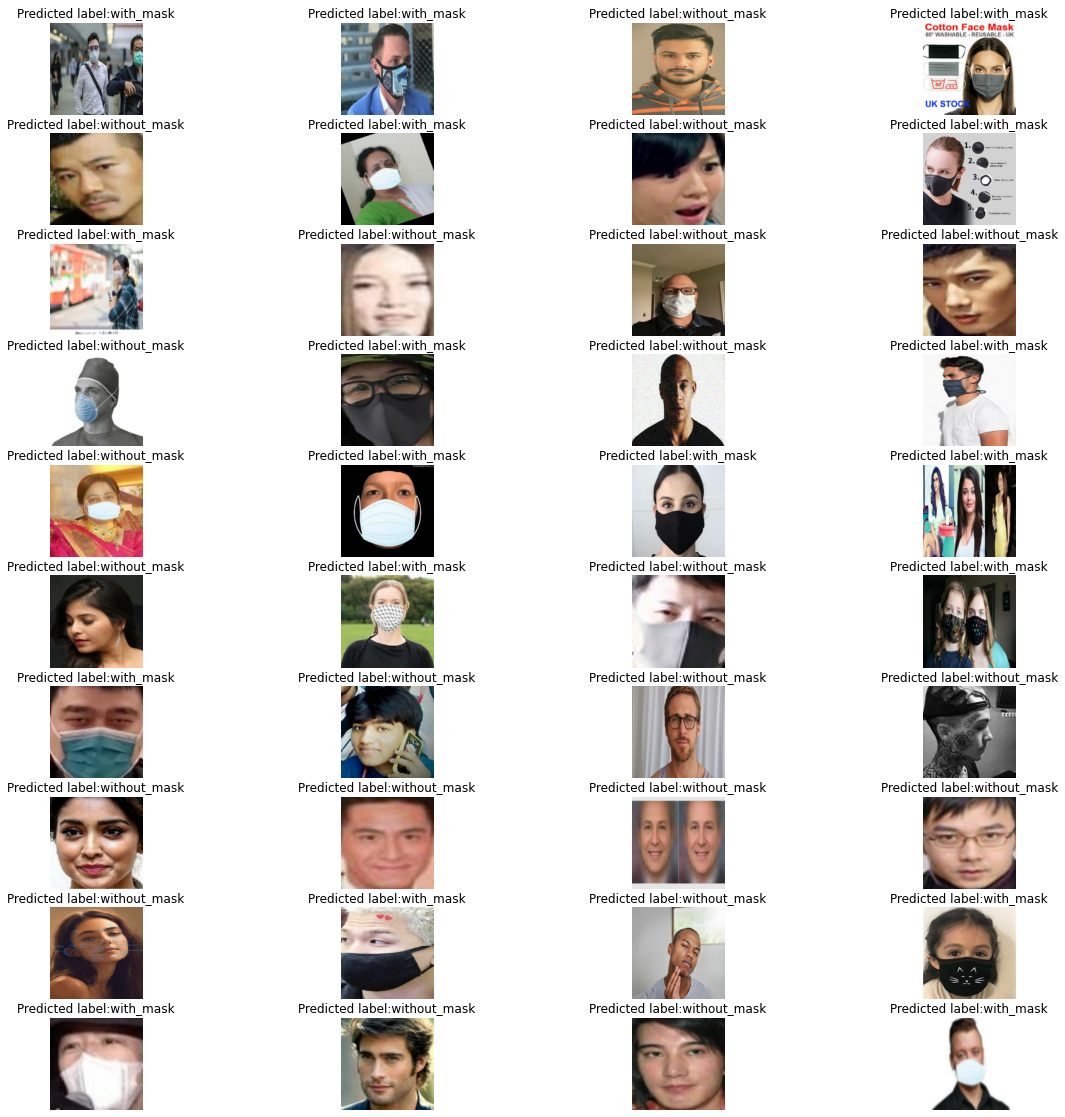

In [17]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

Checking for scores.

In [18]:
scores = model.evaluate(test_data, verbose=0)
print(scores[1] * 100)

92.31787919998169


**Experimenting with different structures of model**

In this one flatten was used.

In [19]:
model_1 = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),     
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')                                
])

In [20]:
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Training the model.**

In [21]:
retVal_1 = model_1.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
152/152 [==============================] - 12s 73ms/step - loss: 1.5167 - accuracy: 0.7203 - val_loss: 0.2679 - val_accuracy: 0.8921
Epoch 2/15
152/152 [==============================] - 11s 71ms/step - loss: 0.2564 - accuracy: 0.9017 - val_loss: 0.2178 - val_accuracy: 0.9159
Epoch 3/15
152/152 [==============================] - 11s 71ms/step - loss: 0.2272 - accuracy: 0.9126 - val_loss: 0.2103 - val_accuracy: 0.9232
Epoch 4/15
152/152 [==============================] - 11s 71ms/step - loss: 0.2058 - accuracy: 0.9158 - val_loss: 0.2148 - val_accuracy: 0.9159
Epoch 5/15
152/152 [==============================] - 11s 71ms/step - loss: 0.1705 - accuracy: 0.9334 - val_loss: 0.1700 - val_accuracy: 0.9285
Epoch 6/15
152/152 [==============================] - 11s 70ms/step - loss: 0.1455 - accuracy: 0.9451 - val_loss: 0.2236 - val_accuracy: 0.9166
Epoch 7/15
152/152 [==============================] - 11s 70ms/step - loss: 0.1622 - accuracy: 0.9399 - val_loss: 0.1565 - val_accuracy:

It took me a little bit more time for training in case of using flatten which increased the size of the model.

Am i correct?

Visualizing the trainging process

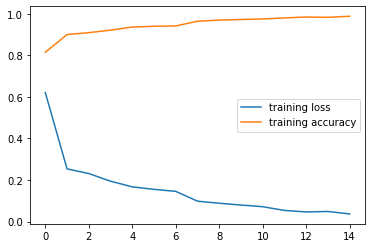

In [22]:
plt.plot(retVal_1.history['loss'], label='training loss')
plt.plot(retVal_1.history['accuracy'], label='training accuracy')
plt.legend()

I think this curves look better than previous ones, aren't them?

Let's match the predicted labels with real images.

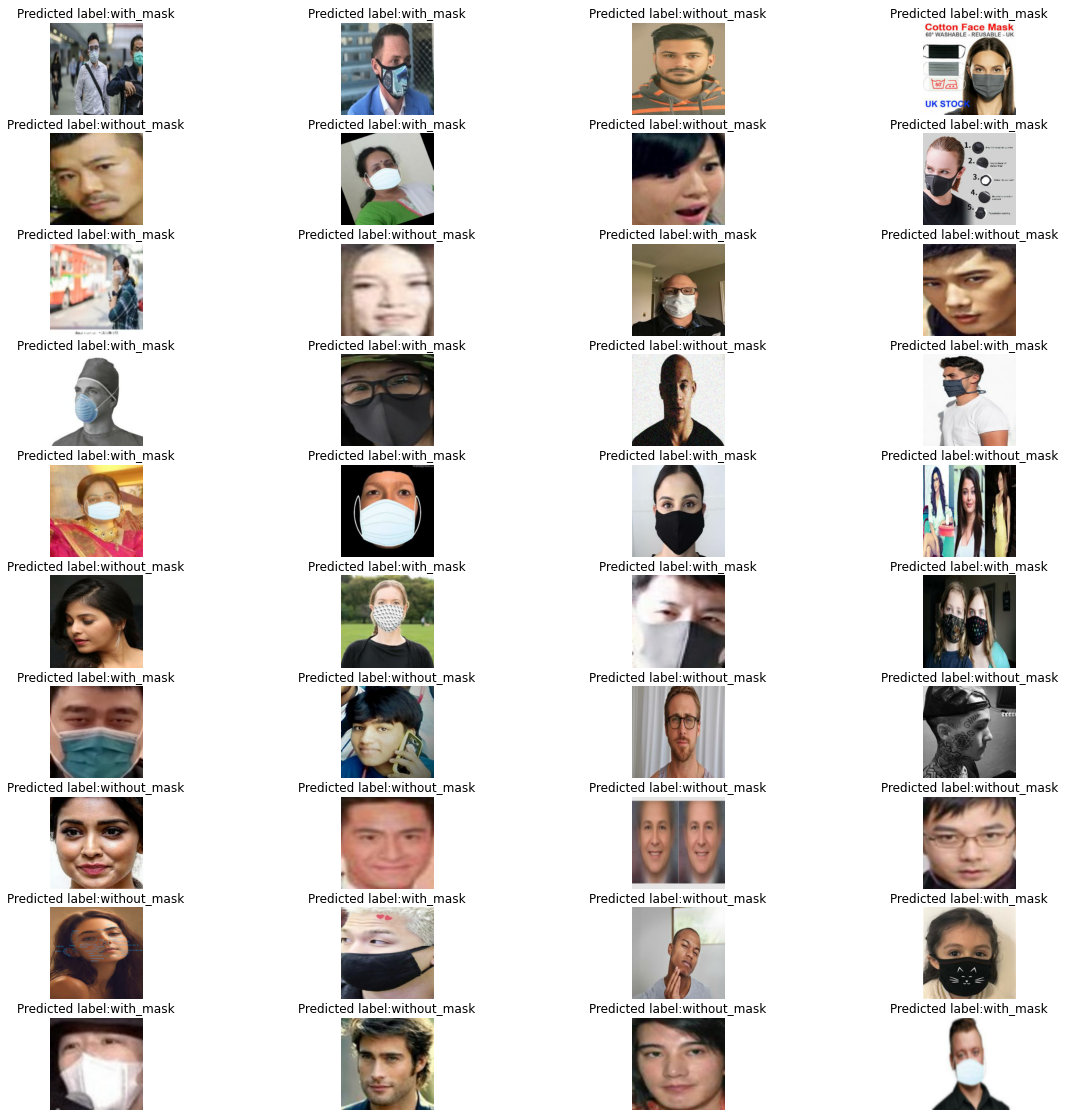

In [23]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_1.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [24]:
scores = model_1.evaluate(test_data, verbose=0)
print(scores[1] * 100)

94.0397322177887


The last custom model with 3 layers of convolutions and subsamplings

In [25]:
model_2 = tf.keras.models.Sequential([
    layers.experimental.preprocessing.Rescaling(1. / 255),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [26]:
model_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [27]:
retVal_2 = model_2.fit(train_data, validation_data=test_data, epochs=15)

Epoch 1/15
152/152 [==============================] - 4s 23ms/step - loss: 0.6276 - accuracy: 0.7131 - val_loss: 0.2518 - val_accuracy: 0.8914
Epoch 2/15
152/152 [==============================] - 3s 22ms/step - loss: 0.2795 - accuracy: 0.8886 - val_loss: 0.2289 - val_accuracy: 0.8901
Epoch 3/15
152/152 [==============================] - 3s 22ms/step - loss: 0.2334 - accuracy: 0.9036 - val_loss: 0.1930 - val_accuracy: 0.9119
Epoch 4/15
152/152 [==============================] - 3s 22ms/step - loss: 0.1998 - accuracy: 0.9172 - val_loss: 0.2155 - val_accuracy: 0.9086
Epoch 5/15
152/152 [==============================] - 3s 22ms/step - loss: 0.1904 - accuracy: 0.9232 - val_loss: 0.1852 - val_accuracy: 0.9139
Epoch 6/15
152/152 [==============================] - 3s 22ms/step - loss: 0.1497 - accuracy: 0.9362 - val_loss: 0.1507 - val_accuracy: 0.9437
Epoch 7/15
152/152 [==============================] - 3s 22ms/step - loss: 0.1388 - accuracy: 0.9438 - val_loss: 0.1572 - val_accuracy: 0.9364

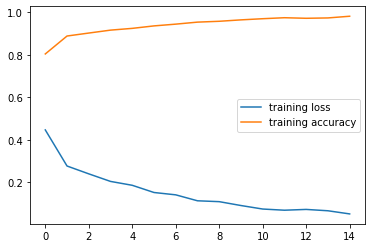

In [28]:
plt.plot(retVal_2.history['loss'], label='training loss')
plt.plot(retVal_2.history['accuracy'], label='training accuracy')
plt.legend()

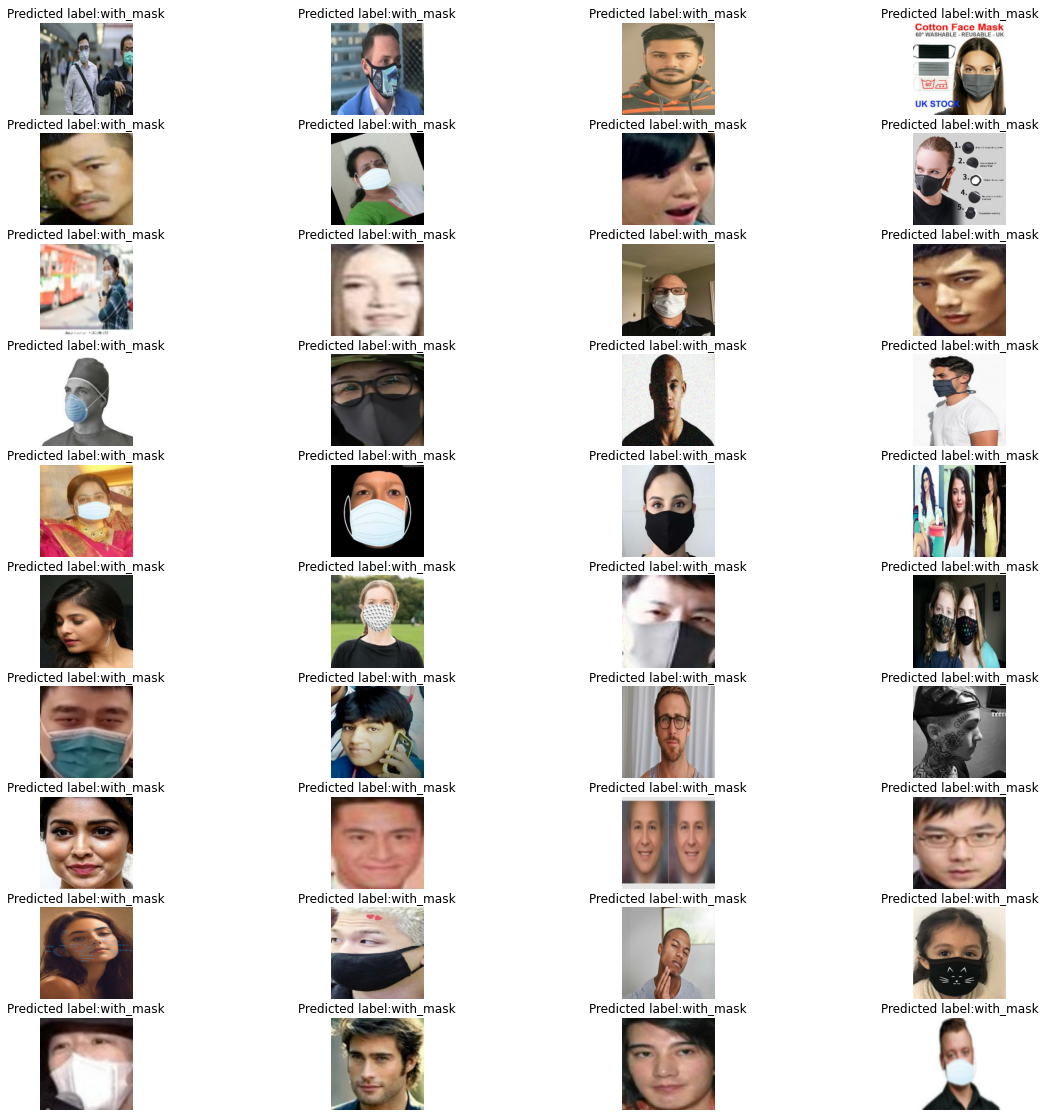

In [29]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_2.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [30]:
scores = model_2.evaluate(test_data, verbose=0)
print(scores[1] * 100)

95.43046355247498


**Transfer learning**

Let's use VGG16,VGG19, Incsption v3, ResNet50, Xception CNNs.

**VGG16**

include_top=False means that won't include the part of the VGG16 that is dedicated to classification.

(Only Convolutional part will be included)

weights='imagenet' means that we want to use learnt weights from imagenet dataset.

In [31]:
VGG16_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


58892288/58889256 [==============================] - 0s 0us/step


trainable=False means that we don't want to teach convolutional part of the model.

In [32]:
VGG16_model.trainable = False

Let's see all layers and amount of parameters of the vgg16.

In [33]:
VGG16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Let's create model based on vgg16

In [34]:
model_3 = tf.keras.models.Sequential([
    VGG16_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [35]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 19,433,793
Trainable params: 4,719,105
Non-trainable params: 14,714,688
_________________________________________________________________


In terms of vgg16 had been already trained we need to set a low learing rate for convergence.


In [36]:
model_3.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Training model. 5 epochs will be enought due to part of the model had been already trained


In [37]:
retVal_3 = model_3.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 17s 100ms/step - loss: 4.4319 - accuracy: 0.6873 - val_loss: 0.3746 - val_accuracy: 0.9457
Epoch 2/5
152/152 [==============================] - 14s 94ms/step - loss: 0.8567 - accuracy: 0.9195 - val_loss: 0.2124 - val_accuracy: 0.9709
Epoch 3/5
152/152 [==============================] - 14s 94ms/step - loss: 0.3610 - accuracy: 0.9556 - val_loss: 0.1475 - val_accuracy: 0.9768
Epoch 4/5
152/152 [==============================] - 14s 94ms/step - loss: 0.2961 - accuracy: 0.9618 - val_loss: 0.1468 - val_accuracy: 0.9788
Epoch 5/5
152/152 [==============================] - 14s 93ms/step - loss: 0.1590 - accuracy: 0.9758 - val_loss: 0.1534 - val_accuracy: 0.9788


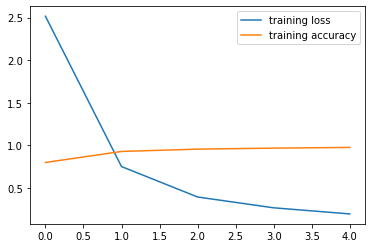

In [38]:
plt.plot(retVal_3.history['loss'], label='training loss')
plt.plot(retVal_3.history['accuracy'], label='training accuracy')
plt.legend()

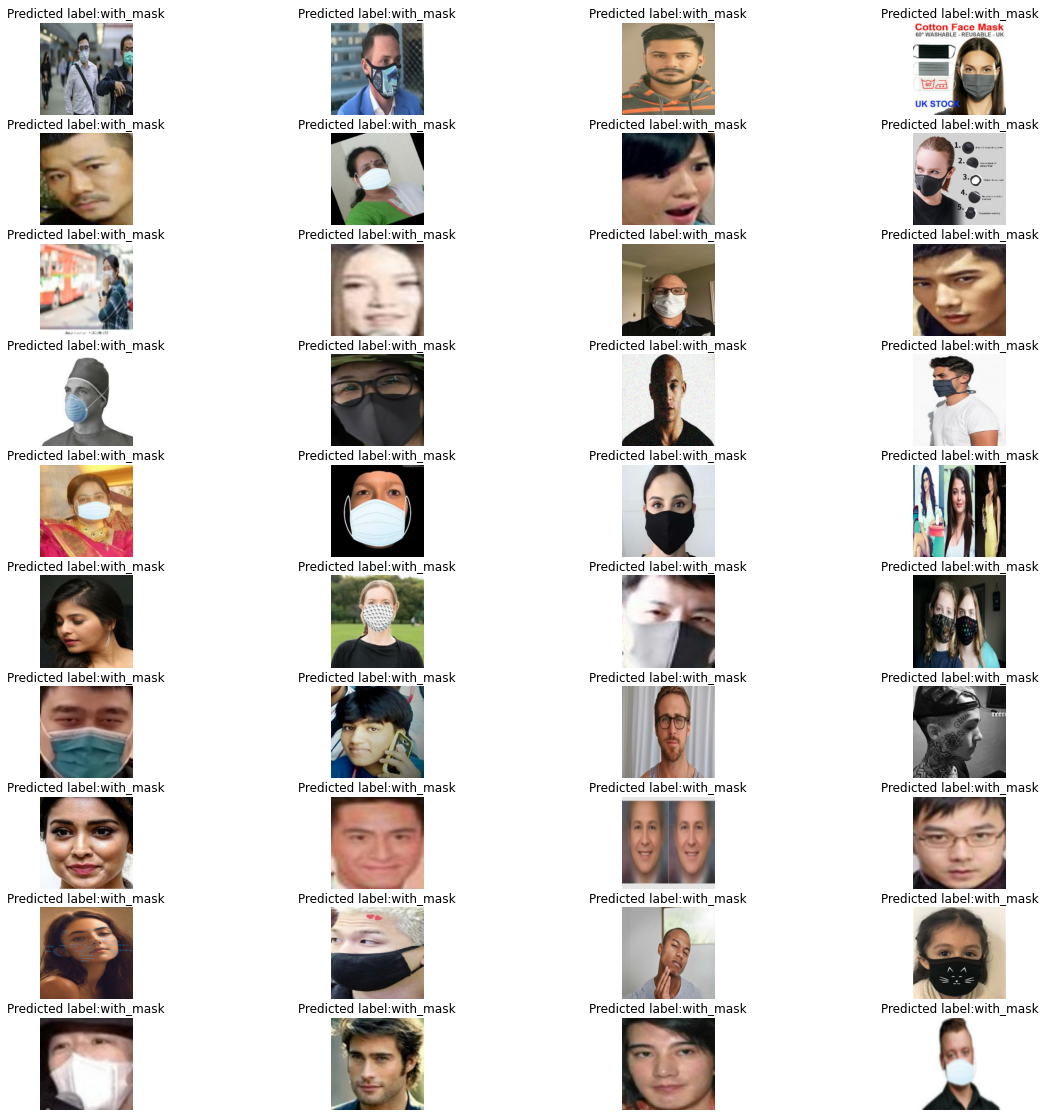

In [39]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_3.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [40]:
scores = model_3.evaluate(test_data, verbose=0)
print(scores[1] * 100)

97.88079261779785


**Fine tuning**

Let's unfreeze last VGG16's convolutional block

In [41]:
VGG16_model.trainable = True
trainable = False
for layer in VGG16_model.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [42]:
model_3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 19,433,793
Trainable params: 11,798,529
Non-trainable params: 7,635,264
_________________________________________________________________


In [43]:
model_3.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

In [44]:
model_3.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 16s 103ms/step - loss: 0.1219 - accuracy: 0.9820 - val_loss: 0.1048 - val_accuracy: 0.9848
Epoch 2/5
152/152 [==============================] - 15s 101ms/step - loss: 0.0478 - accuracy: 0.9923 - val_loss: 0.0622 - val_accuracy: 0.9887
Epoch 3/5
152/152 [==============================] - 15s 102ms/step - loss: 0.0309 - accuracy: 0.9956 - val_loss: 0.0671 - val_accuracy: 0.9887
Epoch 4/5
152/152 [==============================] - 15s 102ms/step - loss: 0.0214 - accuracy: 0.9948 - val_loss: 0.0547 - val_accuracy: 0.9907
Epoch 5/5
152/152 [==============================] - 15s 102ms/step - loss: 0.0147 - accuracy: 0.9981 - val_loss: 0.0866 - val_accuracy: 0.9907


**VGG19**

In [45]:
VGG19_model = VGG19(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

80142336/80134624 [==============================] - 1s 0us/step


trainable=False means that we don't want to teach convolutional part of the model.

In [46]:
VGG19_model.trainable = False

Let's see all layers and amount of parameters of the vgg16.

In [47]:
VGG19_model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Let's create model based on vgg19

In [48]:
model_4 = tf.keras.models.Sequential([
    VGG19_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [49]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 24,743,489
Trainable params: 4,719,105
Non-trainable params: 20,024,384
_________________________________________________________________


In terms of vgg19 had been already trained we need to set a low learing rate for convergence.


In [50]:
model_4.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Training model. 5 epochs will be enought due to part of the model had been already trained


In [51]:
retVal_4 = model_4.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 18s 114ms/step - loss: 3.2451 - accuracy: 0.7250 - val_loss: 0.2627 - val_accuracy: 0.9583
Epoch 2/5
152/152 [==============================] - 17s 112ms/step - loss: 0.5428 - accuracy: 0.9366 - val_loss: 0.1659 - val_accuracy: 0.9702
Epoch 3/5
152/152 [==============================] - 17s 112ms/step - loss: 0.3107 - accuracy: 0.9611 - val_loss: 0.1301 - val_accuracy: 0.9762
Epoch 4/5
152/152 [==============================] - 17s 112ms/step - loss: 0.2156 - accuracy: 0.9700 - val_loss: 0.1221 - val_accuracy: 0.9788
Epoch 5/5
152/152 [==============================] - 17s 112ms/step - loss: 0.1147 - accuracy: 0.9824 - val_loss: 0.1027 - val_accuracy: 0.9808


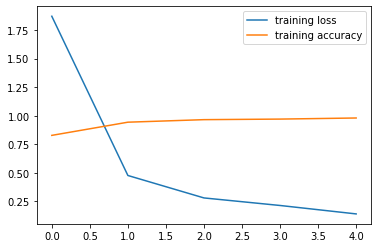

In [52]:
plt.plot(retVal_4.history['loss'], label='training loss')
plt.plot(retVal_4.history['accuracy'], label='training accuracy')
plt.legend()

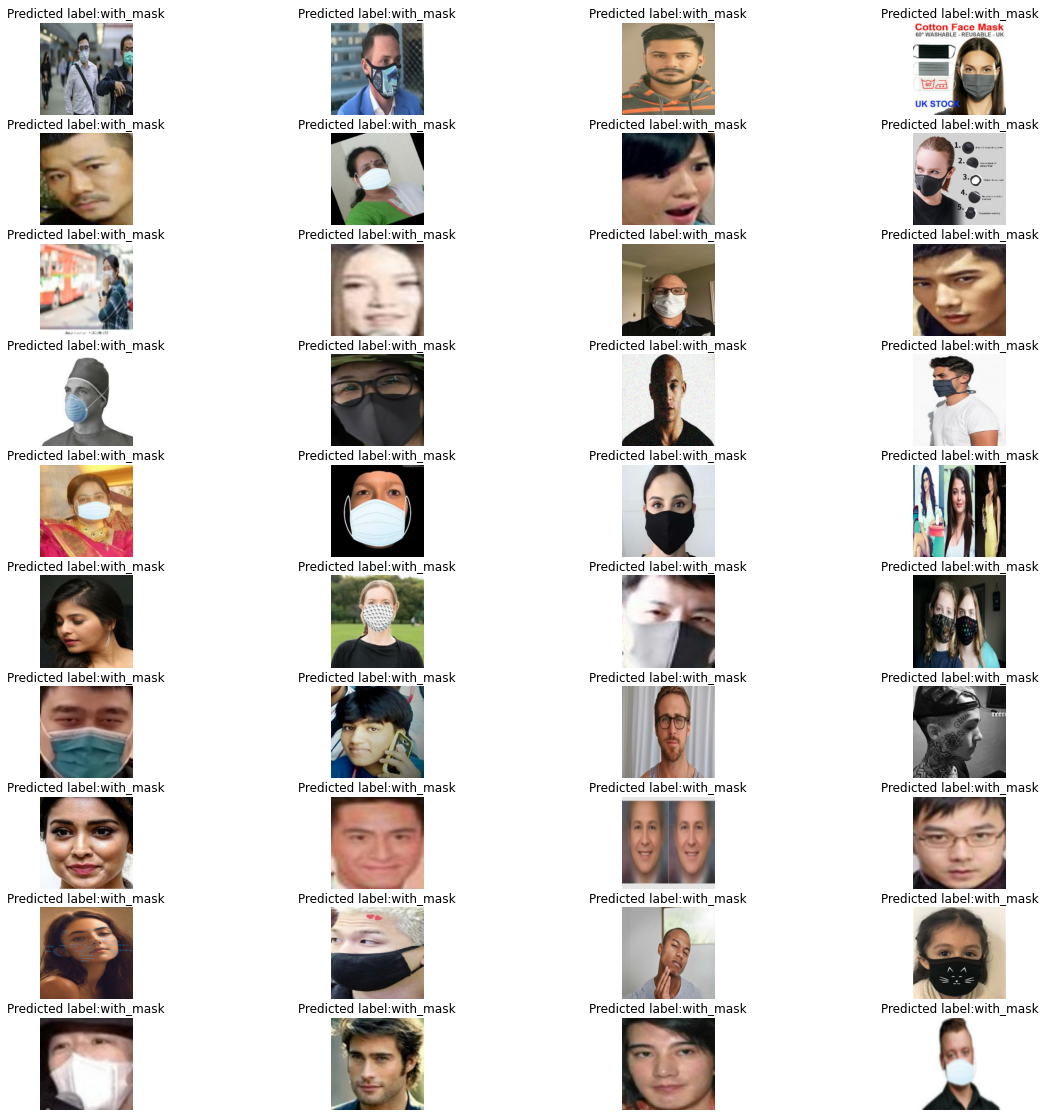

In [53]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_4.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [54]:
scores = model_4.evaluate(test_data, verbose=0)
print(scores[1] * 100)

98.07947278022766


**Fine tuning**

Let's unfreeze last VGG19's convolutional block

In [86]:
VGG19_model.trainable = True
trainable = False
for layer in VGG19_model.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [87]:
model_4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 6, 6, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               4718848   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 257       
Total params: 24,743,489
Trainable params: 14,158,337
Non-trainable params: 10,585,152
_________________________________________________________________


In [88]:
model_4.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

In [89]:
model_4.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 20s 126ms/step - loss: 0.0947 - accuracy: 0.9845 - val_loss: 0.1064 - val_accuracy: 0.9881
Epoch 2/5
152/152 [==============================] - 19s 124ms/step - loss: 0.0406 - accuracy: 0.9945 - val_loss: 0.0613 - val_accuracy: 0.9901
Epoch 3/5
152/152 [==============================] - 19s 124ms/step - loss: 0.0244 - accuracy: 0.9956 - val_loss: 0.0518 - val_accuracy: 0.9901
Epoch 4/5
152/152 [==============================] - 19s 123ms/step - loss: 0.0115 - accuracy: 0.9982 - val_loss: 0.0522 - val_accuracy: 0.9947
Epoch 5/5
152/152 [==============================] - 19s 123ms/step - loss: 0.0059 - accuracy: 0.9985 - val_loss: 0.0416 - val_accuracy: 0.9947


**InceptionV3**

In [55]:
incV3_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

87916544/87910968 [==============================] - 1s 0us/step


trainable=False means that we don't want to teach convolutional part of the model.

In [56]:
incV3_model.trainable = False

Let's see all layers and amount of parameters of the InceptionV3.

In [57]:
incV3_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 99, 99, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 99, 99, 32)   96          conv2d_10[0][0]                  
__________________________________________________________________________________________________
activation (Activation)         (None, 99, 99, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

Let's create model based on InceptionV3

In [58]:
model_5 = tf.keras.models.Sequential([
    incV3_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [59]:
model_5.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 4, 4, 2048)        21802784  
_________________________________________________________________
flatten_4 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               8388864   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 257       
Total params: 30,191,905
Trainable params: 8,389,121
Non-trainable params: 21,802,784
_________________________________________________________________


In terms of InceptionV3 had been already trained we need to set a low learing rate for convergence.


In [60]:
model_5.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Training model. 5 epochs will be enought due to part of the model had been already trained


In [61]:
retVal_5 = model_5.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 15s 72ms/step - loss: 10.5486 - accuracy: 0.6386 - val_loss: 1.1903 - val_accuracy: 0.7907
Epoch 2/5
152/152 [==============================] - 9s 59ms/step - loss: 1.3944 - accuracy: 0.7559 - val_loss: 0.5550 - val_accuracy: 0.7974
Epoch 3/5
152/152 [==============================] - 9s 59ms/step - loss: 0.6233 - accuracy: 0.7574 - val_loss: 0.4903 - val_accuracy: 0.7887
Epoch 4/5
152/152 [==============================] - 9s 59ms/step - loss: 0.4785 - accuracy: 0.7905 - val_loss: 0.4369 - val_accuracy: 0.8139
Epoch 5/5
152/152 [==============================] - 9s 59ms/step - loss: 0.4229 - accuracy: 0.8073 - val_loss: 0.4144 - val_accuracy: 0.8232


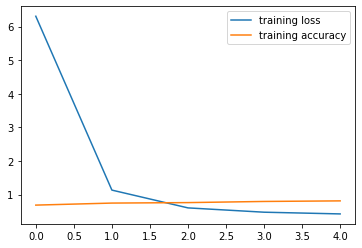

In [62]:
plt.plot(retVal_5.history['loss'], label='training loss')
plt.plot(retVal_5.history['accuracy'], label='training accuracy')
plt.legend()

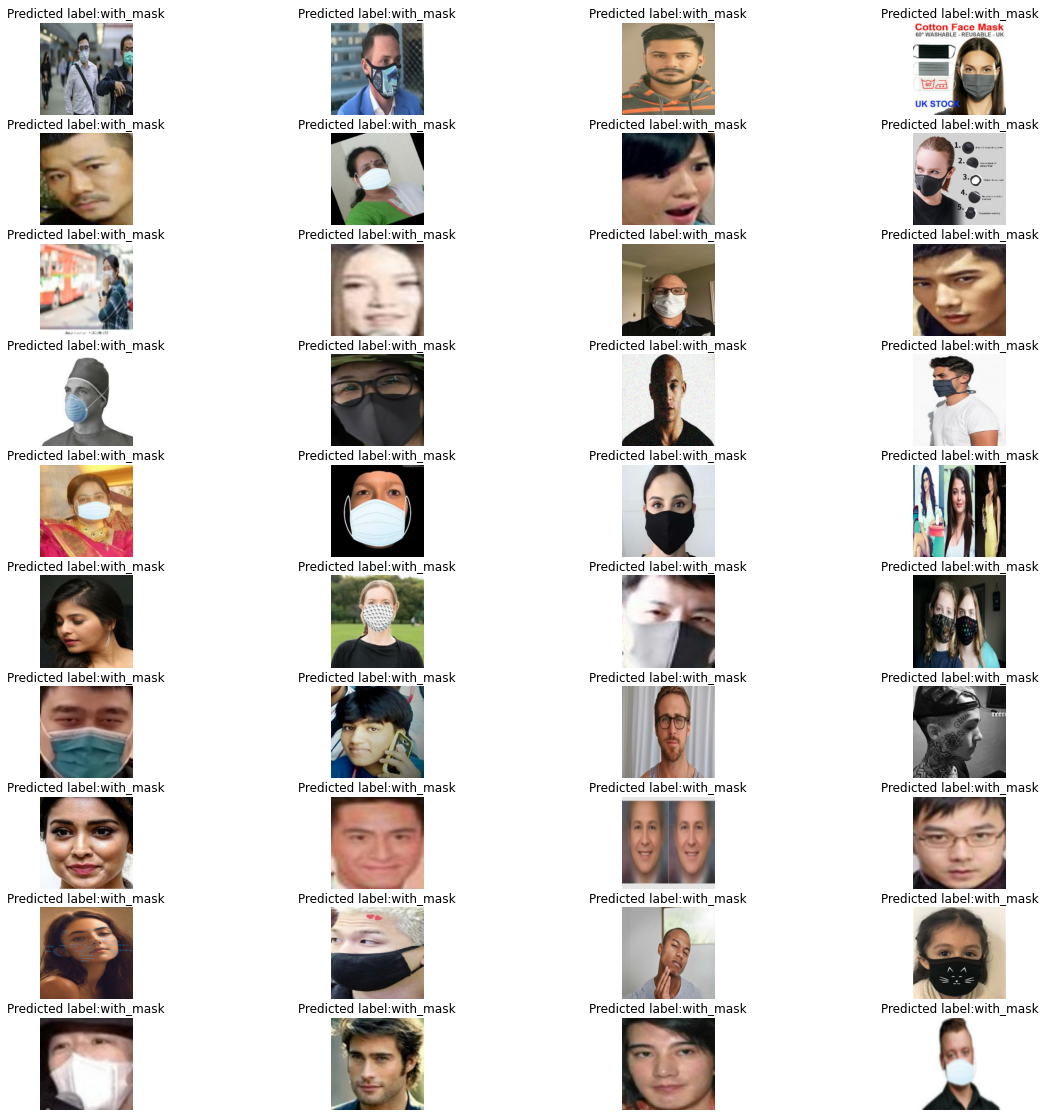

In [63]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_5.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [64]:
scores = model_5.evaluate(test_data, verbose=0)
print(scores[1] * 100)

82.31788277626038


**ResNet50**

In [65]:
ResNet50_model = VGG16(weights='imagenet', include_top=False, input_shape=(200, 200, 3))


trainable=False means that we don't want to teach convolutional part of the model.

In [66]:
ResNet50_model.trainable = False

Let's see all layers and amount of parameters of the vgg16.

In [67]:
ResNet50_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

Let's create model based on ResNet50

In [68]:
model_6 = tf.keras.models.Sequential([
    ResNet50_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [69]:
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 19,433,793
Trainable params: 4,719,105
Non-trainable params: 14,714,688
_________________________________________________________________


In terms of ResNet50 had been already trained we need to set a low learing rate for convergence.


In [70]:
model_6.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

Training model. 5 epochs will be enought due to part of the model had been already trained


In [71]:
retVal_6 = model_6.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 15s 96ms/step - loss: 3.0100 - accuracy: 0.7404 - val_loss: 0.3191 - val_accuracy: 0.9576
Epoch 2/5
152/152 [==============================] - 14s 93ms/step - loss: 0.5938 - accuracy: 0.9266 - val_loss: 0.2292 - val_accuracy: 0.9656
Epoch 3/5
152/152 [==============================] - 14s 93ms/step - loss: 0.2779 - accuracy: 0.9630 - val_loss: 0.1560 - val_accuracy: 0.9735
Epoch 4/5
152/152 [==============================] - 14s 93ms/step - loss: 0.1964 - accuracy: 0.9694 - val_loss: 0.1392 - val_accuracy: 0.9748
Epoch 5/5
152/152 [==============================] - 14s 93ms/step - loss: 0.1546 - accuracy: 0.9758 - val_loss: 0.1221 - val_accuracy: 0.9781


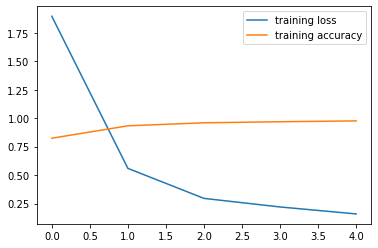

In [72]:
plt.plot(retVal_6.history['loss'], label='training loss')
plt.plot(retVal_6.history['accuracy'], label='training accuracy')
plt.legend()

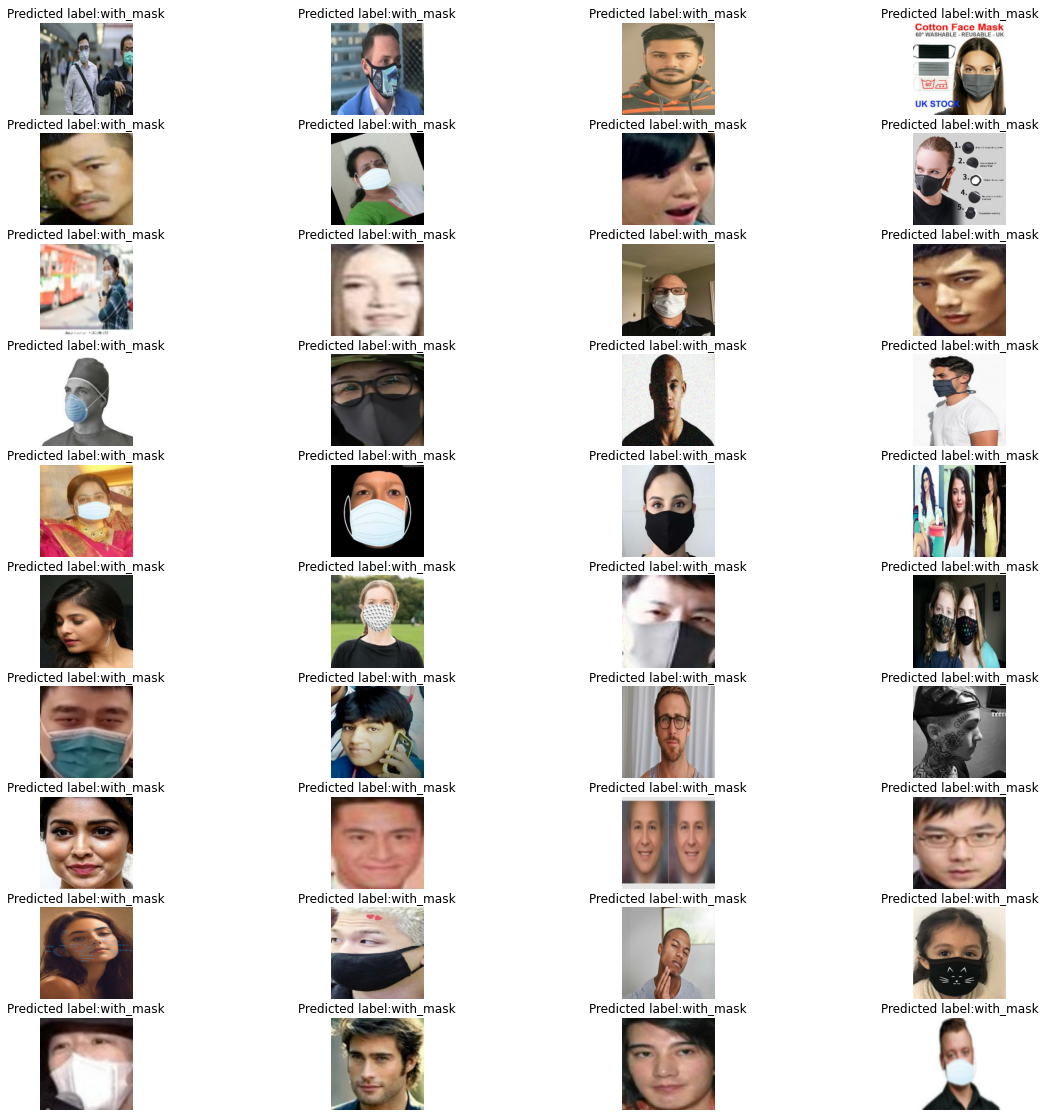

In [73]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_6.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [74]:
scores = model_6.evaluate(test_data, verbose=0)
print(scores[1] * 100)

97.81457185745239


**Fine tuning**

Let's unfreeze last ResNet50's convolutional block

In [90]:
ResNet50_model.trainable = True
trainable = False
for layer in ResNet50_model.layers:
    if layer.name == 'block5_conv1':
        trainable = True
    layer.trainable = trainable

In [91]:
model_6.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               4718848   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 19,433,793
Trainable params: 11,798,529
Non-trainable params: 7,635,264
_________________________________________________________________


In [92]:
model_6.compile(loss='binary_crossentropy', optimizer=Adam(lr=1e-5), metrics=['accuracy'])

In [94]:
model_6.fit(train_data, validation_data=test_data, epochs=3)

Epoch 1/3
152/152 [==============================] - 15s 102ms/step - loss: 0.0106 - accuracy: 0.9982 - val_loss: 0.0414 - val_accuracy: 0.9921
Epoch 2/3
152/152 [==============================] - 15s 102ms/step - loss: 0.0096 - accuracy: 0.9977 - val_loss: 0.0459 - val_accuracy: 0.9921
Epoch 3/3
152/152 [==============================] - 15s 101ms/step - loss: 0.0041 - accuracy: 0.9990 - val_loss: 0.0524 - val_accuracy: 0.9934


**InceptionV4/InceptionResNet**

In [75]:
InceptionV4_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3))

219062272/219055592 [==============================] - 1s 0us/step


In [76]:
InceptionV4_model.trainable = False

In [77]:
InceptionV4_model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv2d_104 (Conv2D)             (None, 99, 99, 32)   864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 99, 99, 32)   96          conv2d_104[0][0]                 
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 99, 99, 32)   0           batch_normalization_94[0][0]     
________________________________________________________________________________

In [78]:
model_7 = tf.keras.models.Sequential([
    InceptionV4_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')                                
])

In [79]:
model_7.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 4, 4, 1536)        54336736  
_________________________________________________________________
flatten_6 (Flatten)          (None, 24576)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               6291712   
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 257       
Total params: 60,628,705
Trainable params: 6,291,969
Non-trainable params: 54,336,736
_________________________________________________________________


In [80]:
model_7.compile(optimizer=Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

In [81]:
retVal_7 = model_7.fit(train_data, validation_data=test_data, epochs=5)

Epoch 1/5
152/152 [==============================] - 34s 153ms/step - loss: 48.9405 - accuracy: 0.5528 - val_loss: 1.2788 - val_accuracy: 0.5881
Epoch 2/5
152/152 [==============================] - 20s 131ms/step - loss: 1.5819 - accuracy: 0.5886 - val_loss: 0.7707 - val_accuracy: 0.6212
Epoch 3/5
152/152 [==============================] - 20s 131ms/step - loss: 0.7350 - accuracy: 0.5712 - val_loss: 0.6738 - val_accuracy: 0.6464
Epoch 4/5
152/152 [==============================] - 20s 131ms/step - loss: 0.6595 - accuracy: 0.5819 - val_loss: 0.6455 - val_accuracy: 0.6139
Epoch 5/5
152/152 [==============================] - 20s 131ms/step - loss: 0.6475 - accuracy: 0.5902 - val_loss: 0.6404 - val_accuracy: 0.6331


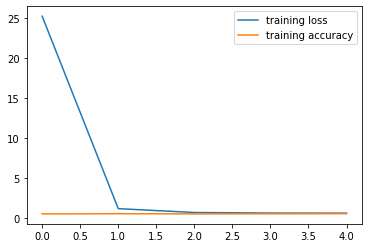

In [82]:
plt.plot(retVal_7.history['loss'], label='training loss')
plt.plot(retVal_7.history['accuracy'], label='training accuracy')
plt.legend()

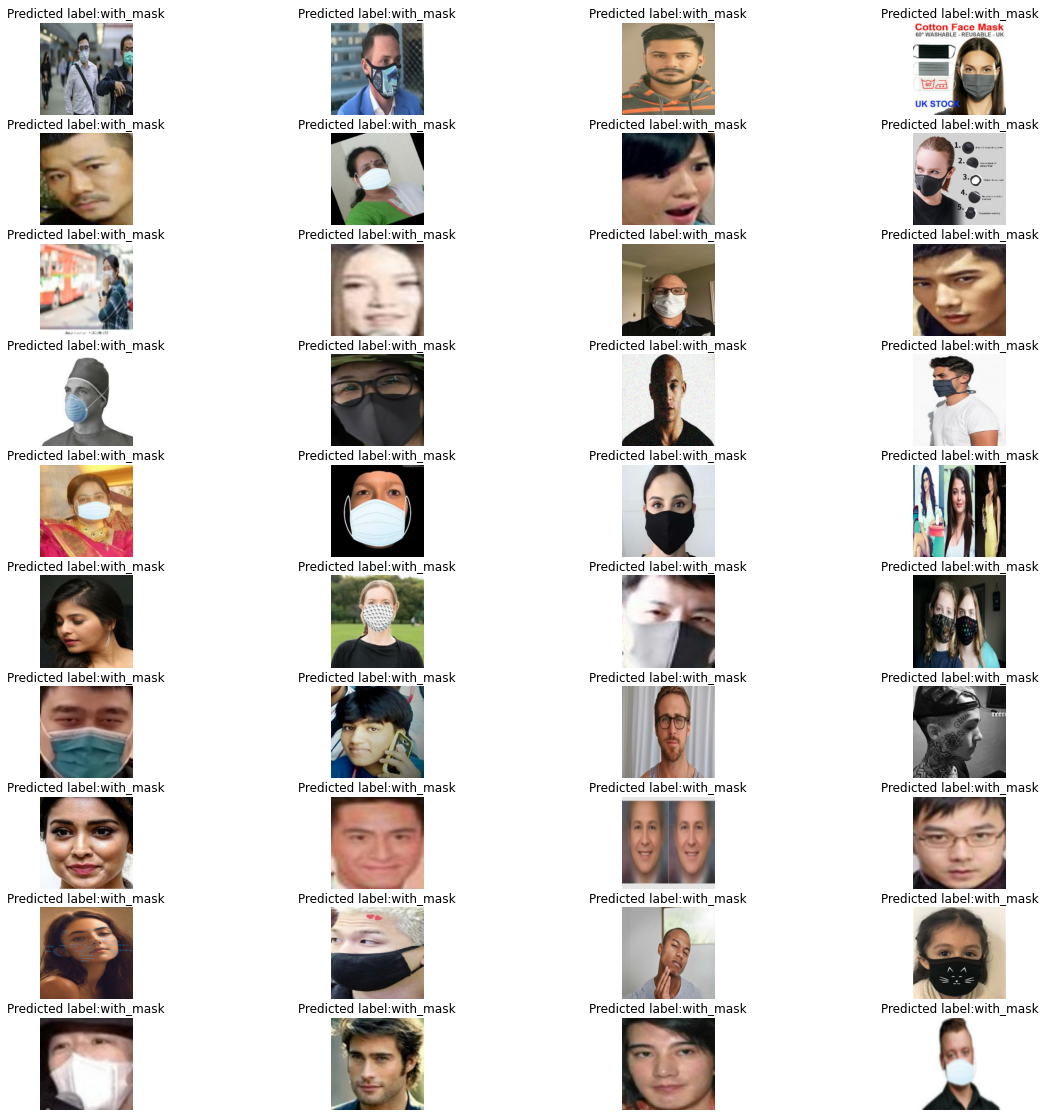

In [83]:
plt.figure(figsize=(20, 20))
for images, labels in test_data.take(1):
    predictions = model_7.predict(images)
    predlabel = []

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])

    for i in range(40):
        ax = plt.subplot(10, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('Predicted label:' + predlabel[i])
        plt.axis('off')
        plt.grid(True)

In [84]:
scores = model_7.evaluate(test_data, verbose=0)
print(scores[1] * 100)

63.31126093864441


Saving **models**

In [85]:
model.save('maskDetector.h5')
model_1.save('maskDetector_1.h5')
model_2.save('maskDetector_2.h5')
model_3.save('maskDetector_3.h5')
model_4.save('maskDetector_4.h5')
model_5.save('maskDetector_5.h5')
model_6.save('maskDetector_6.h5')
model_7.save('maskDetector_7.h5')